In [29]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt # matplotlib for plotting

import re # regular expressions

import warnings
warnings.filterwarnings("ignore") #because who likes annoying warnings

plt.style.use('ggplot') #prettier pictures

import datetime      #for datetime operations
import calendar      #for calendar for datetime operations
import time          #to get the system time
plt.rcParams['figure.figsize'] = [16, 10] #set default figure size


In [3]:
df = pd.read_csv('../data/clean_train.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1436572 entries, 0 to 1436571
Data columns (total 26 columns):
Unnamed: 0                  1436572 non-null int64
id                          1436572 non-null object
vendor_id                   1436572 non-null int64
pickup_datetime             1436572 non-null object
dropoff_datetime            1436572 non-null object
passenger_count             1436572 non-null int64
pickup_longitude            1436572 non-null float64
pickup_latitude             1436572 non-null float64
dropoff_longitude           1436572 non-null float64
dropoff_latitude            1436572 non-null float64
store_and_fwd_flag          1436572 non-null int64
trip_duration               1436572 non-null int64
date                        1436572 non-null object
minimum temperature         1436572 non-null int64
precipitation               1436572 non-null float64
snow fall                   1436572 non-null float64
snow depth                  1436572 non-null float64
lo

In [5]:
df['pickup_datetime'] = pd.to_datetime(df.pickup_datetime)
df['dropoff_datetime'] = pd.to_datetime(df.dropoff_datetime)
df['date'] = pd.to_datetime(df.date)

In [8]:
df =  df.drop(['Unnamed: 0'], 1)

In [9]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,snow depth,log_trip_duration,distance_haversine,distance_dummy_manhattan,direction,Hour,dayofweek,Month,pickup_cluster,dropoff_cluster
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,0,...,0.0,6.122493,1.498521,1.735433,99.970196,17,0,3,10,7
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,0,...,0.0,6.498282,1.805507,2.430506,-117.153768,0,6,6,8,14
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,0,...,0.0,7.661527,6.385098,8.203575,-159.680165,11,1,1,10,0
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,0,...,0.0,6.063785,1.485498,1.661331,-172.737700,19,2,4,0,0
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,0,...,0.0,6.077642,1.188588,1.199457,179.473585,13,5,3,6,6


First, a scatter plot of the rides throughout the geolocation coordinates shows a rough map of New York City. We can see a concentration of rides going to JFK and La Guardia airports away from the central hub of rides that is in Manhattan.

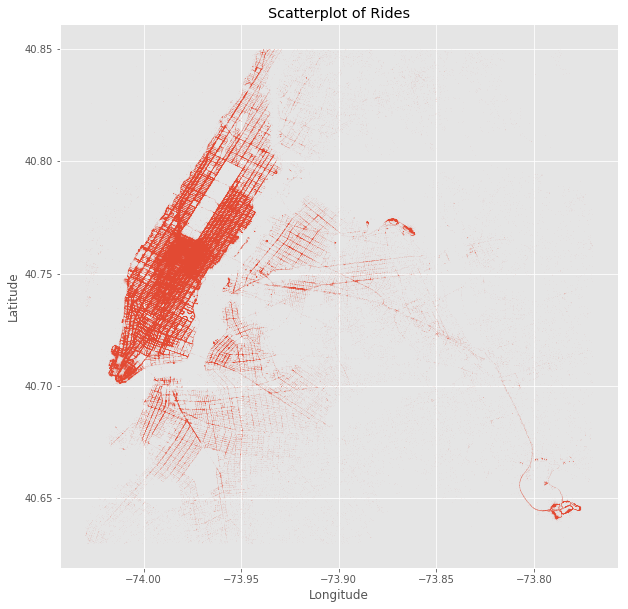

In [10]:
longitude = list(df.pickup_longitude) + list(df.dropoff_longitude)
latitude = list(df.pickup_latitude) + list(df.dropoff_latitude)
plt.figure(figsize = (10,10))
plt.title('Scatterplot of Rides')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.plot(longitude,latitude,'.', alpha = 0.4, markersize = 0.05)
plt.show()


Next, looking at the "log_trip_duration" column, the distribution of ride duration seems to be roughly normal (especially since we already filtered out the riders that were more than 2 standard deviations away from the mean, such as the 10hr anomaly rides)

[Text(0.5, 1.0, 'Distribution of ride durations')]

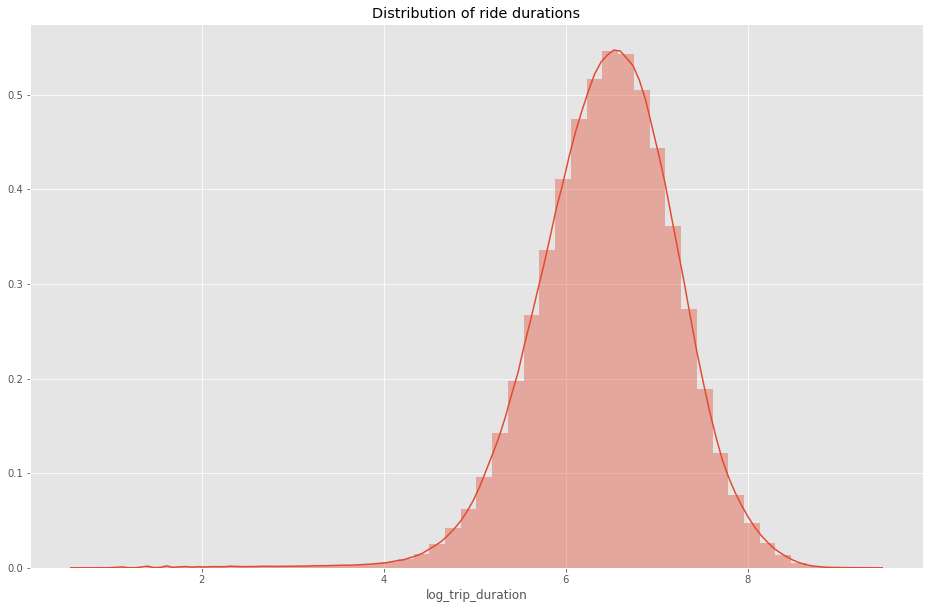

In [30]:
sns.distplot(df.log_trip_duration).set(title = 'Distribution of ride durations')

Text(0, 0.5, 'Count (rides)')

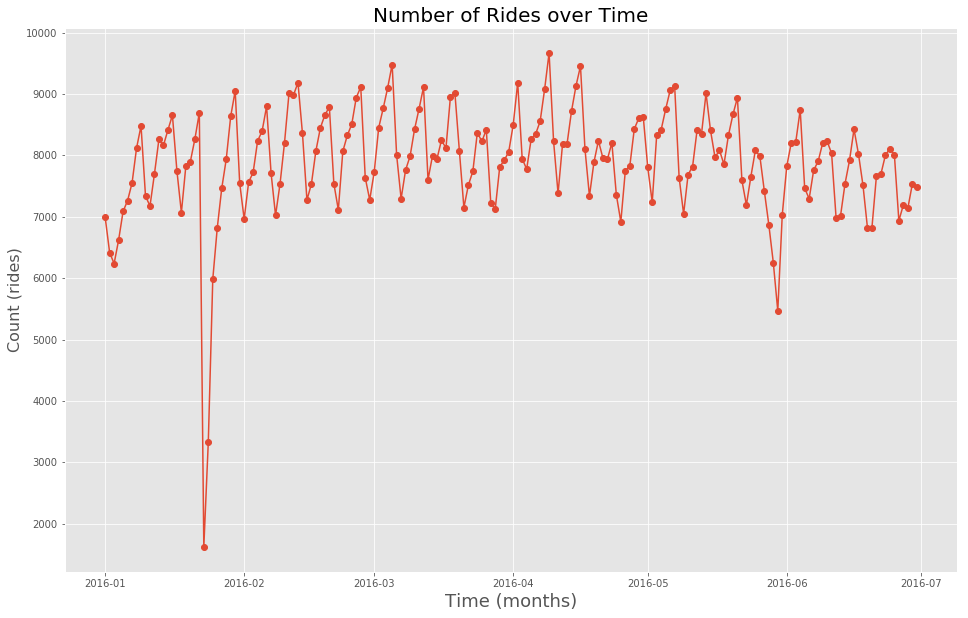

In [31]:
plt.plot(df.groupby('date').count()[['id']], 'o-')
plt.title('Number of Rides over Time', fontsize=20)
plt.xlabel('Time (months)', fontsize=18)
plt.ylabel('Count (rides)', fontsize=16)

Looking at the line plot below, we can see that there is a major dip in the number of taxi rides in late January. While this may seem like an anomaly, there are other factors that should be taken into consideration. One feasible explanation is that there was a snowstorm, and there could have easily been a driving ban for the day where the rides drop dramatically. 

Just a quick look at the data on January 23rd shows that there was snow fall of 27.3 inches, which may be enough to warrant the fact that not that many cabs were out on the road that day. 

Another error that may have occured is shown on the plot blelow when looking at the dates of each month on the 1st. It seems that the datetime dayofweek method has mistakenly placed the January 2,3,4,5 dates flipped into the months. I find it hard to believe that there was any snow at all on May 1st. 

[Text(0, 0.5, 'Snow fall (inches)'),
 Text(0.5, 0, 'Date'),
 Text(0.5, 1.0, 'Snow fall per day')]

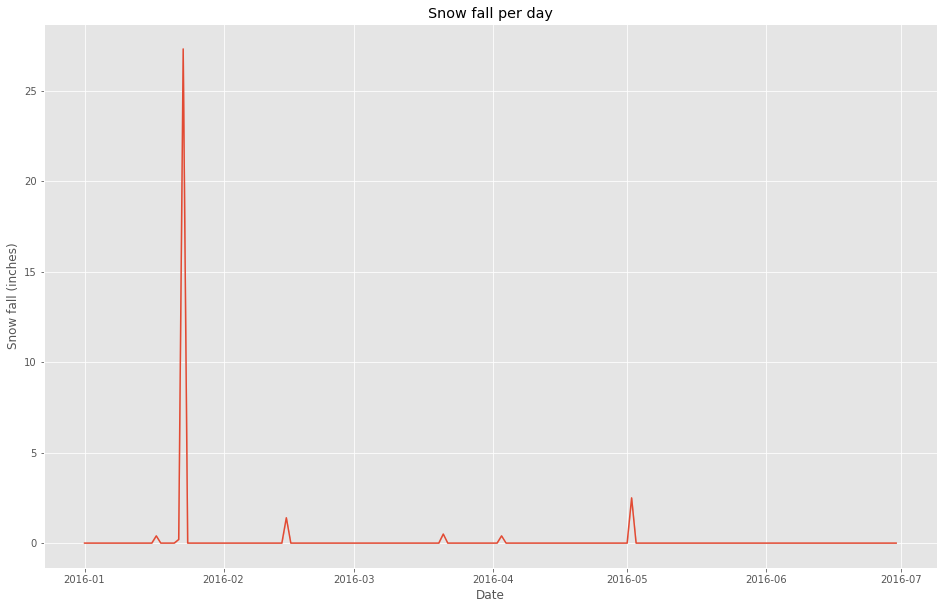

In [32]:
sns.lineplot(x="date", y="snow fall", data=df).set(title = 'Snow fall per day', ylabel = 'Snow fall (inches)', xlabel= 'Date')


In [14]:
df[df.date == ('2016-01-23')]['snow fall'].mean()

27.300000000000374

In [15]:
#creating additional time increments to plot by

df['Hour'] = df['pickup_datetime'].dt.hour
df['dayofweek'] = df['pickup_datetime'].dt.dayofweek
df['Month'] = df['pickup_datetime'].dt.month

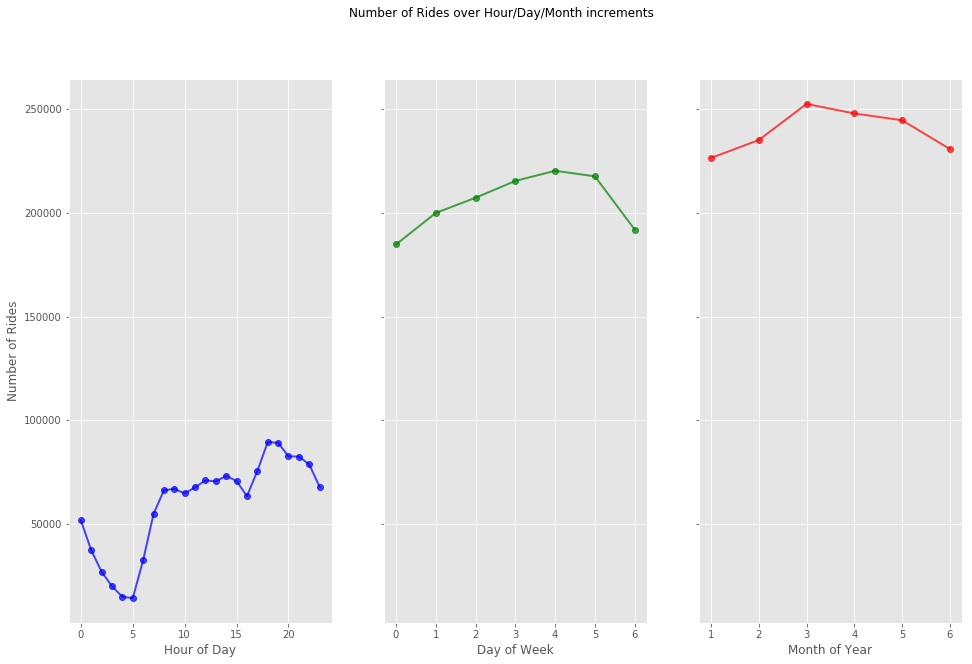

In [33]:
fig, ax = plt.subplots(ncols=3, sharey=True)
ax[0].plot(df.groupby('Hour').count()['id'], 'bo-', lw=2, alpha=0.7)
ax[1].plot(df.groupby('dayofweek').count()['id'], 'go-', lw=2, alpha=0.7)
ax[2].plot(df.groupby('Month').count()['id'], 'ro-', lw=2, alpha=0.7)
ax[0].set_xlabel('Hour of Day')
ax[1].set_xlabel('Day of Week')
ax[2].set_xlabel('Month of Year')
ax[0].set_ylabel('Number of Rides')
fig.suptitle('Number of Rides over Hour/Day/Month increments')
plt.show()

The number of rides taken over the day hits a minimum at 5am and a maximum at around 6pm. 

The number of rides taken over the days of the week is at a minimum on Monday (0 on the x axis) and gradually rises to peak on Friday (4) beforeo dropping sharply on Sunday. 

Over the months of the first half of the year, january has the least number of rides, while March has the most.

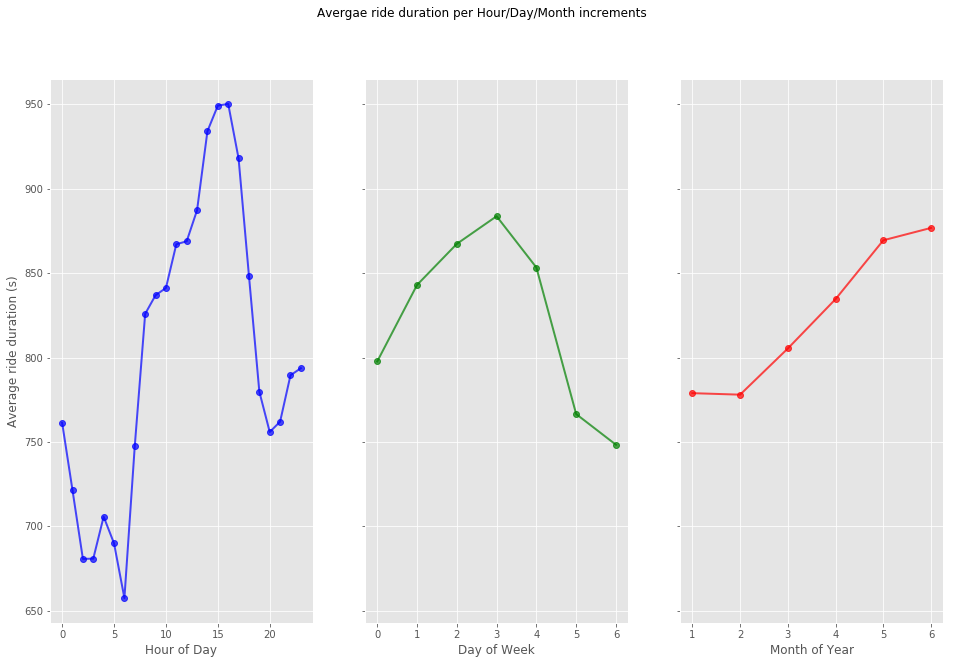

In [34]:
fig, ax = plt.subplots(ncols=3, sharey=True)
ax[0].plot(df.groupby('Hour')['trip_duration'].mean(), 'bo-', lw=2, alpha=0.7)
ax[1].plot(df.groupby('dayofweek')['trip_duration'].mean(), 'go-', lw=2, alpha=0.7)
ax[2].plot(df.groupby('Month')['trip_duration'].mean(), 'ro-', lw=2, alpha=0.7)
ax[0].set_xlabel('Hour of Day')
ax[1].set_xlabel('Day of Week')
ax[2].set_xlabel('Month of Year')
ax[0].set_ylabel('Average ride duration (s)')
fig.suptitle('Avergae ride duration per Hour/Day/Month increments')
plt.show()

During the day, the shortest trips also occur around 5am, when there are the fewest number of trips. This may be due to the lack of traffic at the hour, and the lack of need for people to go "far" in a cab at that hour. The average ride duration seems to peak at around 3pm each day, and continues to decrease in duration utnil around 8pm. Surprisingly enough, the longest average ride durations did not occur at the customary "rush hour" times of 5-6pm. 

During the week, Sunday has the lowest average ride duration followed by Saturday. Somewhat intuitively, more people have to work and have a pressing need for cabs during the weekdays, and that may be attributed to the higher taxi ride durations that gradually peak on Thursdays. On average, people are in taxis for less amount of times on weekends. 

Finally, over the coures of the first 6 months of the year, the the average ride duration is shortest during January-February, and grows almost linearly until June (when the average ride duration is at highest).

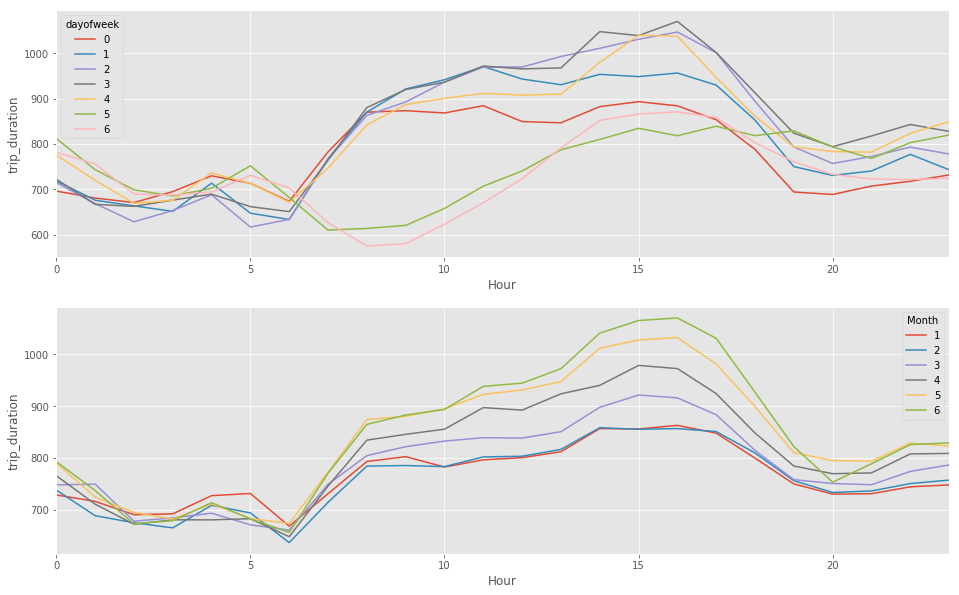

In [35]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

#weekday rides plotting

weekday_rides= pd.DataFrame(df.groupby(['dayofweek', 'Hour'])['trip_duration'].mean())
weekday_rides['unit'] = 1
weekday_rides.reset_index(inplace =True)
sns.tsplot(data=weekday_rides, time  = 'Hour', unit = 'unit', condition = 'dayofweek', value= 'trip_duration', ax=ax1)

###### monthly rides plotting 

monthly_rides= pd.DataFrame(df.groupby(['Month', 'Hour'])['trip_duration'].mean())
monthly_rides['unit'] = 1
monthly_rides.reset_index(inplace =True)
sns.tsplot(data=monthly_rides, time  = 'Hour', unit = 'unit', condition = 'Month', value= 'trip_duration', ax=ax2)



The plots above reaffirm the points made from the previous two sets of line plots.
We see a noticeable decrease in average trip duration during the weekends, and we also see the highest average trip durations during June and May. 

Since we have the haversine distance and the manhattan distance, we can calculate the average speed of the taxis throughout their trip, by dividing the distance by the trip duration. We can see if there is a trend in the average speeds of the vehicles throughout different hours of day, days of week, or months. 

However, since speed is calculated using two of the columns in the data, it wouldn't actually add any predictive value in modelling. For demonstration purposes, we will look at the average speed of taxis using the manhattan distance and trip duration.

First, looking at the average distance traveled per trip in NYC based on varying time segments.

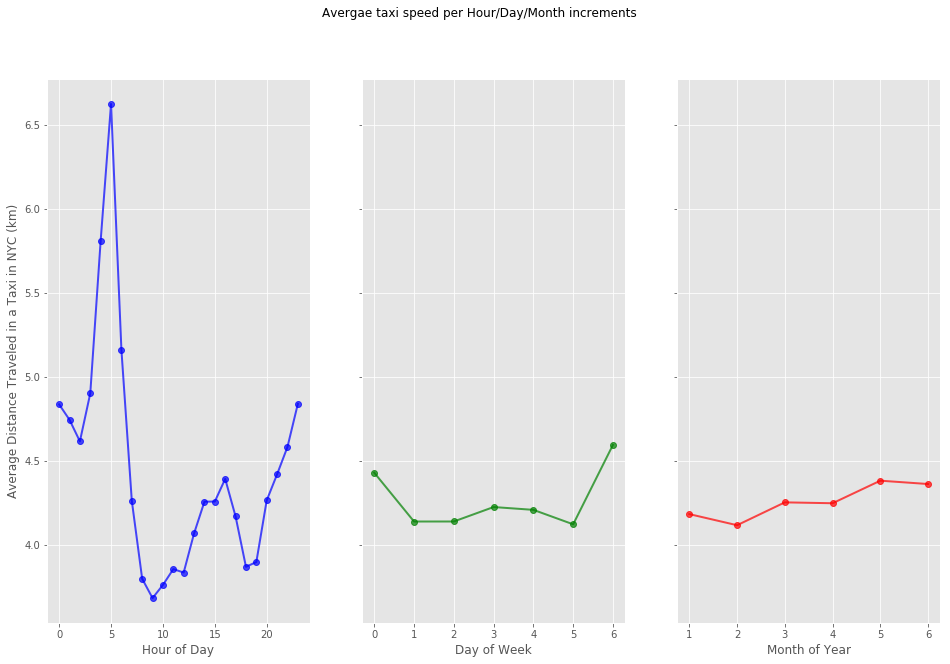

In [36]:
fig, ax = plt.subplots(ncols=3, sharey=True)
ax[0].plot(df.groupby('Hour')['distance_dummy_manhattan'].mean(), 'bo-', lw=2, alpha=0.7)
ax[1].plot(df.groupby('dayofweek')['distance_dummy_manhattan'].mean(), 'go-', lw=2, alpha=0.7)
ax[2].plot(df.groupby('Month')['distance_dummy_manhattan'].mean(), 'ro-', lw=2, alpha=0.7)
ax[0].set_xlabel('Hour of Day')
ax[1].set_xlabel('Day of Week')
ax[2].set_xlabel('Month of Year')
ax[0].set_ylabel('Average Distance Traveled in a Taxi in NYC (km)')
fig.suptitle('Avergae taxi speed per Hour/Day/Month increments')
plt.show()

The highest average distance trips tend to happen around 5 am during the days. This may be attributed to the early morning filghts that people take,, who may wish to conserve their energy by taking a cab to the airports relatively far away instead of the public transit. In fact, there may not even be a running public transit to the airports as such an early hour. We can see that the average trip distance over the weeks and the months tend to be between 4 to 4.5 km. However, looking at the histogram below, we can see that most trips are in fact around 1 to 2 km. It seems that there are a few abnormally long distance trips that are brining the average up a bit higher than what we woudl expect. After all, the histogram below is clearly heavily left skewed.

[Text(0, 0.5, 'Frequency'), Text(0.5, 0, 'Distance Traveled in Taxi (km)')]

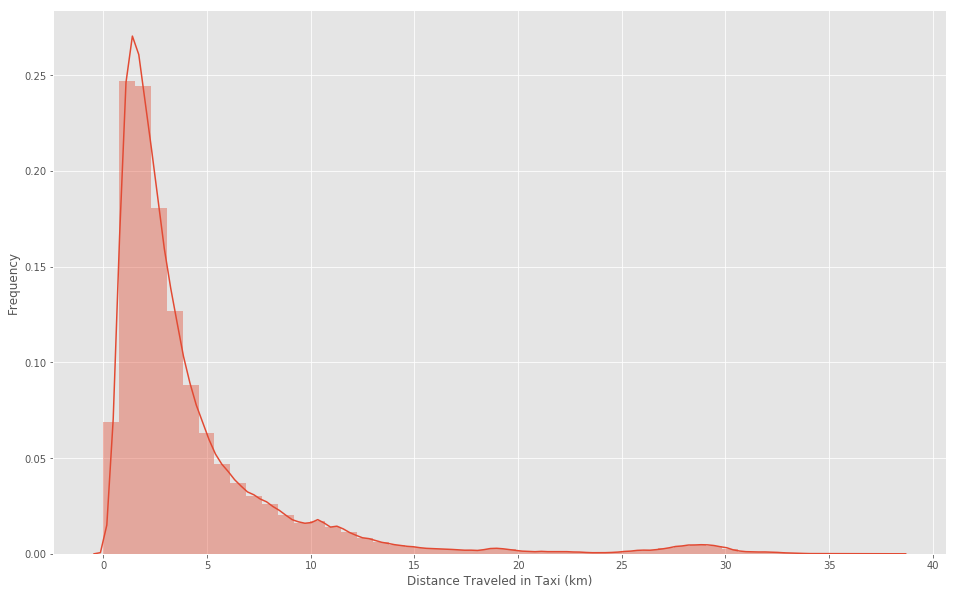

In [37]:
sns.distplot(df['distance_dummy_manhattan']).set(xlabel='Distance Traveled in Taxi (km)', ylabel = 'Frequency')

In [39]:
#We will only calculate the speed using manhattan distance
df.loc[:, 'avg_speed_m'] = df['distance_dummy_manhattan'] / (df['trip_duration'] / 3600)

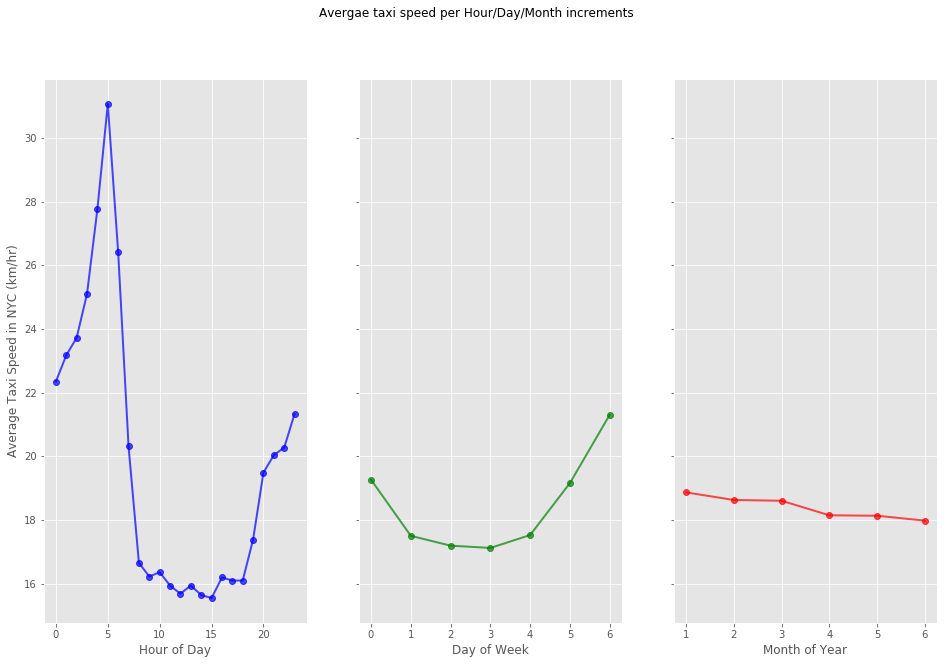

In [40]:
fig, ax = plt.subplots(ncols=3, sharey=True)
ax[0].plot(df.groupby('Hour')['avg_speed_m'].mean(), 'bo-', lw=2, alpha=0.7)
ax[1].plot(df.groupby('dayofweek')['avg_speed_m'].mean(), 'go-', lw=2, alpha=0.7)
ax[2].plot(df.groupby('Month')['avg_speed_m'].mean(), 'ro-', lw=2, alpha=0.7)
ax[0].set_xlabel('Hour of Day')
ax[1].set_xlabel('Day of Week')
ax[2].set_xlabel('Month of Year')
ax[0].set_ylabel('Average Taxi Speed in NYC (km/hr)')
fig.suptitle('Avergae taxi speed per Hour/Day/Month increments')
plt.show()

Here we can see that during the day, the taxis are cruising at their fastest average speeds of around 31 km/hr at 5 am, which we know to be a time of day where there are the fewest number of cars around. Otherwise duing the day, starting at around 8am, the cars crawl around 16 km/hr until 6pm, where the speed gradually climbs back up until 5 am of the next day. 

During the week, Sundays have the fastest taxi speeds on average. This is again the day of the week that we know to have the fewest number of cars around. 

As for the months, the highest taxi speeds are in January, and it gradually declines until the average taxi speeds hit their minimum in June. This seems somewhat counterintuitive, since one would think that taxi speeds would be lower during the colder months where there are snow and other adverse weather conditions on the road. 

Finally, since we are done with looking at the average taxi speeds, it would be prudent to drop the column again, since it is of no more use, especially in modelling. 


In [41]:
df = df.drop('avg_speed_m', 1)

[Text(0, 0.5, 'Average Ride Duration (s)'),
 Text(0.5, 0, 'Number of Passengers')]

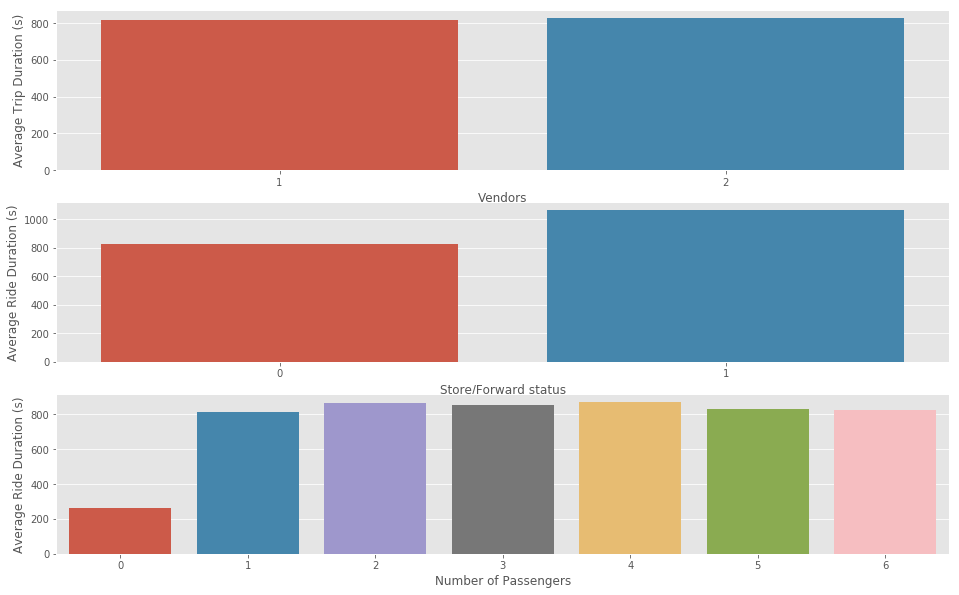

In [42]:
fig = plt.figure()
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

vendor_rides = df.groupby('vendor_id')['trip_duration'].mean()
sns.barplot(vendor_rides.index, vendor_rides.values, ax = ax1).set(xlabel = 'Vendors', ylabel = 'Average Trip Duration (s)')


store_flag =  df.groupby('store_and_fwd_flag')['trip_duration'].mean()
sns.barplot(store_flag.index, store_flag.values, ax = ax2).set(xlabel = 'Store/Forward status', ylabel = 'Average Ride Duration (s)')


num_pass = df.groupby('passenger_count')['trip_duration'].mean()
sns.barplot(num_pass.index, num_pass.values, ax = ax3).set(xlabel = 'Number of Passengers', ylabel = 'Average Ride Duration (s)')


There are also two vendors in the vendor_id section. From the barplot (subplot 1) above, we can see that there is a miniscule difference in average ride times between the two vendors. Intuitively, taxi drivers probably have a "feel" for which route to take at which time of day, and that optimizing their ride durations comes with experience. The difference of around 20 seconds seems to be almost negligeble at this scale.

The "store and forward" flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip

It seems from the barplot (subplot 2) above that the average trip durations do depend on whether or not the trip was logged right away or stored and forwarded. If the taxi did not have access to the servers, it could mean that the store/forward flag status would be 1. This may imply that the taxi was farther away in range where it could not access the server to forward the information right away - also implying that the ride took longer because it was to a destination farther away.

From the last barplot (subplot 3) we can see that there are actually trips recorded with 0 passengers. This seems like an error since a taxi driver wouldn't just turn on the meter to driver somewhere and charge himself. Otherwise, for the passenger counts of 1 through 6 they all have similar average trip durations of around 800 seconds.

Unlike the popular ride sharing applications used by many today, we can assume that most people who ride taxis together are presumably going to the same destination, and the taxi does not need to make multiple stops or take a roundabout route. This may explain how having more passengers does not seem to increase the average ride duration.

In [47]:
df.groupby('passenger_count').size()

passenger_count
0         52
1    1018313
2     206780
3      58971
4      27947
5      76885
6      47624
dtype: int64

Checking out the respective sizes of the passenger counts, we can see that there are only 52 instances of "0" passengers. It is highly likely that either this was an error on the drivers' part, or that it was accidentally recorded as 0 when it should have been another value.

**Perform two sample t test for the results above**

- Does average trip duration differ based on vendor id?
- Does average trip duration differ based on store and forward flag?

In [43]:
v1 = df[df['vendor_id'] == 1]
v2 = df[df['vendor_id'] == 2]

In [50]:
from scipy import stats

two_samp_ttest = stats.ttest_ind(v1['trip_duration'], v2['trip_duration'], nan_policy = 'omit')
print('t-statistic: %.3f | p-value: %.5f.' % two_samp_ttest)

t-statistic: -10.044 | p-value: 0.00000.


However when we perform a two sample t-test on the difference between trip duration between the two vendor id's, we see obtain a p value of 0, signifying that there is a difference in average trip duration based on vendor id. Although the difference seemed miniscule at the scale shown in the bar plot above, it seems that there is a difference in average trip duration between the two vendors that is statistically significant.

In [47]:
s1 = df[df['store_and_fwd_flag'] == 1]
s0 = df[df['store_and_fwd_flag'] == 0]

In [49]:
from scipy import stats

two_samp_ttest = stats.ttest_ind(s1['trip_duration'], s0['trip_duration'], nan_policy = 'omit')
print('t-statistic: %.3f | p-value: %.5f.' % two_samp_ttest)

t-statistic: 33.449 | p-value: 0.00000.


Perhaps a bit more apparent from the bar plot visualizations above, we see that the difference in average trip duration is also statistically significant based on the store and forward flag value. Although we do not know the root cause behind why a taxi cannot access the server (therefore forcing the taxi to store and forward the trip to ther servers at a later time, causing the flag to be set at 1), we can know that there is a siginificant difference in average trip duration based on this feature. 

**Features Heatmap**

Finally, when looking at the correlation heatmap of all the variables in the dataframe, we can see that trip duration is highly correlated with both haversine distance and the manhattan distance. Intuitively this makes sense, as longer the distance the taxi has to travel, the longer the trip probably will become. Other than these variables, there doesn't seem to be any suspiciously high correlation values for the rest of the variables.

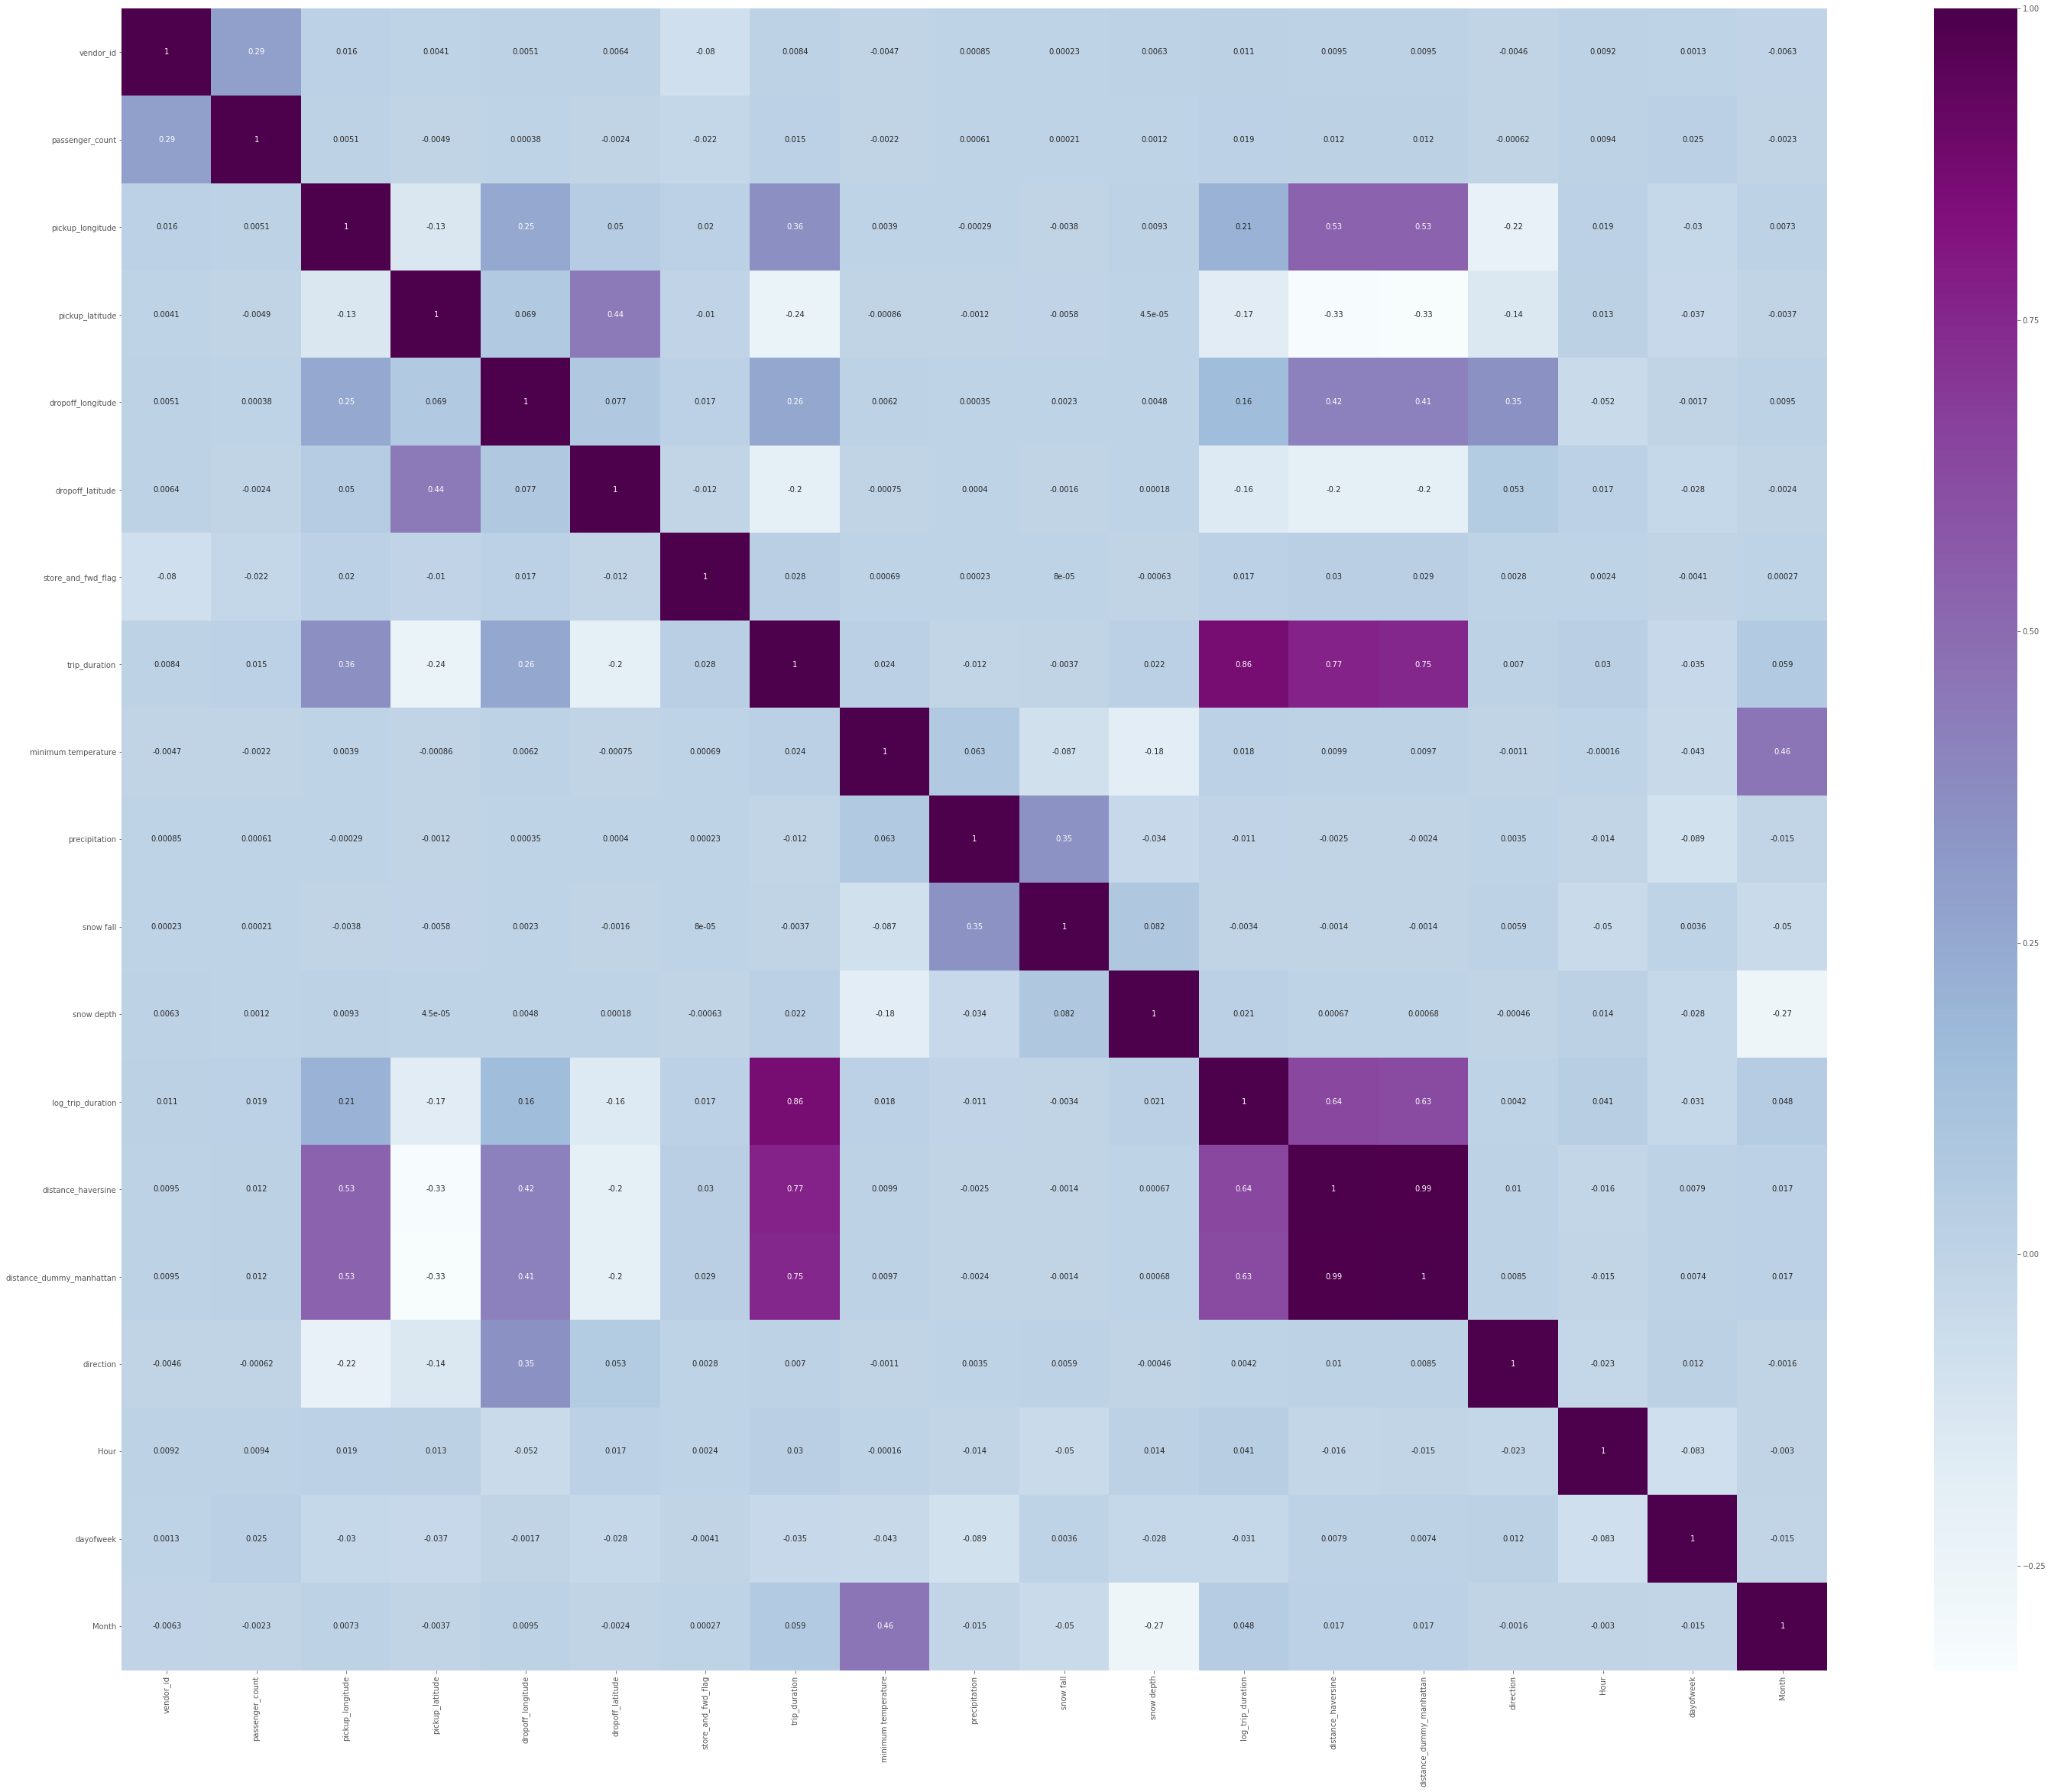

In [48]:
plt.figure(figsize=(50,40))
p = sns.heatmap(df.corr(), annot=True, cmap = "BuPu")